In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dtaidistance import dtw
from scipy.stats import pearsonr
import pandas as pd

In [2]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

### get landmarks from a image

In [3]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

In [4]:
# Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)


I0000 00:00:1724205432.615343       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
# STEP 3: Load the input image.
image = mp.Image.create_from_file("../demo.png")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

In [6]:
detection_result.handedness

[[Category(index=1, score=0.9982233047485352, display_name='Left', category_name='Left')],
 [Category(index=0, score=0.9703705310821533, display_name='Right', category_name='Right')]]

In [21]:
detection_result.hand_landmarks[0][:5]

[NormalizedLandmark(x=0.9416628479957581, y=0.37301987409591675, z=-2.105643943650648e-07, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.8697613477706909, y=0.48007410764694214, z=-0.06635050475597382, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.7555141448974609, y=0.5805624723434448, z=-0.11579294502735138, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.67698734998703, y=0.7072206735610962, z=-0.16241805255413055, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.6321825981140137, y=0.8241401314735413, z=-0.20924235880374908, visibility=0.0, presence=0.0)]

In [7]:
detection_result.hand_world_landmarks[0][:5]

[Landmark(x=0.07849932461977005, y=0.023689312860369682, z=0.04672452062368393, visibility=0.0, presence=0.0),
 Landmark(x=0.05013401061296463, y=0.04298856481909752, z=0.026452749967575073, visibility=0.0, presence=0.0),
 Landmark(x=0.02752123959362507, y=0.057340558618307114, z=0.02228185534477234, visibility=0.0, presence=0.0),
 Landmark(x=0.0005567111074924469, y=0.07864460349082947, z=0.008283674716949463, visibility=0.0, presence=0.0),
 Landmark(x=-0.022308025509119034, y=0.09027789533138275, z=0.006764277815818787, visibility=0.0, presence=0.0)]

### compare 1d series

In [ ]:
# pose 시계열 데이터

In [8]:
# 랜덤 시계열 데이터
np.random.seed(0)
time_series_a = np.cumsum(np.random.rand(20) * 2 - 1)
time_series_b = np.cumsum(np.random.rand(30) * 2 - 1 + np.sin(np.linspace(0, 3 * np.pi, 30)))


In [9]:
distance, paths = dtw.warping_paths(time_series_a, time_series_b, use_c=False)
best_path = dtw.best_path(paths)

# 점수가 낮을 수록 동일함을 의미
similarity_score = distance / len(best_path)

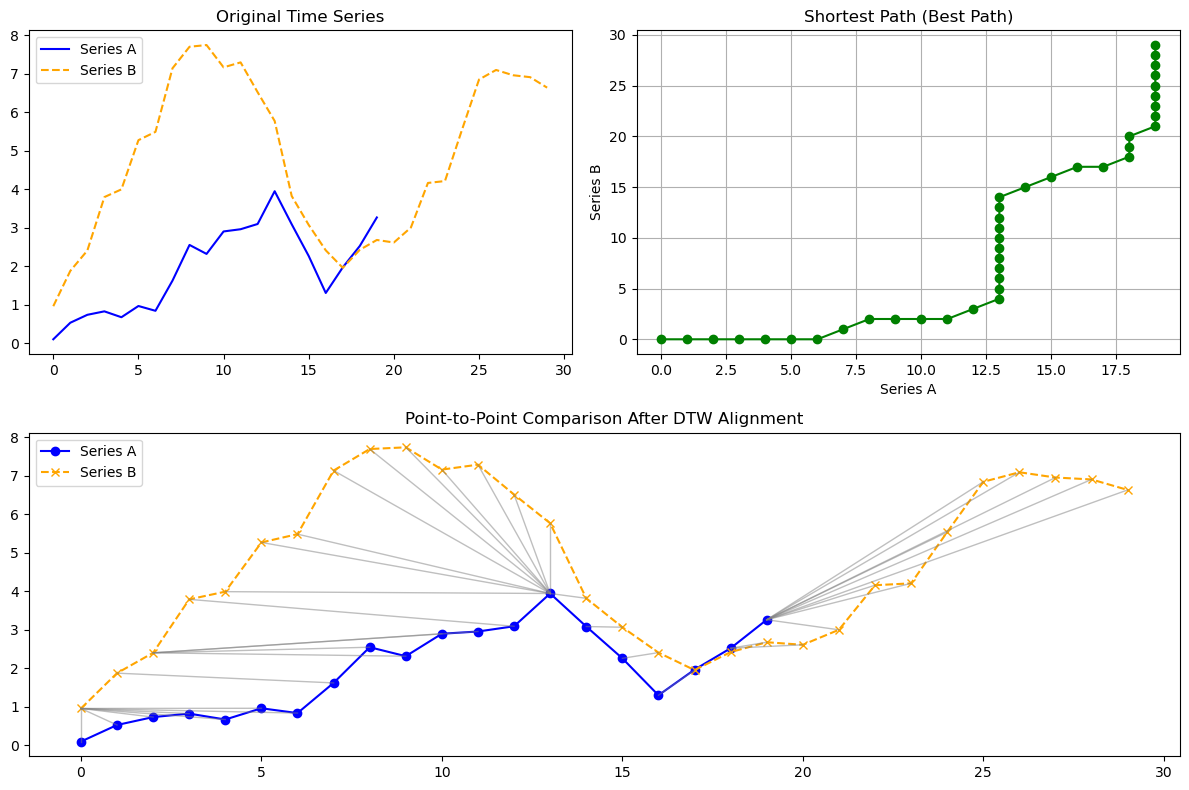

In [10]:
plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(time_series_a, label='Series A', color='blue')
ax1.plot(time_series_b, label='Series B', linestyle='--',color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(time_series_a, label='Series A', color='blue', marker='o')
ax3.plot(time_series_b, label='Series B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [time_series_a[a], time_series_b[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()